In [1]:
#!/usr/bin/env python
# coding: utf-8
# %%

# %%


"""Module containing all simulation tools."""


# %%


import math
import random
import dill as pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# Current Issues

# 1. I think that there will be some funky business with the SpeciesID if we're making new Species
# instances to test out stuff, because loading a Species dictionary into SpeciesList does not
# actually update the speciesID of Species. One potential fix is to make sure that Species.speciesID
# gets updated as well every time we load a new dict of Species.
# 
#     - Maybe to handle this we can let speciesID be a property of SpeciesList rather than Species, so the creation of any Species will have to refer back to SpeciesList to obtain the property

# 2. The neighborData dictionary currently used by the PlantArray and Tile classes is currently
# configured to store SpeciesID as keys, and the number of Adult trees of that species as the value.
# We might want to consider updating this in the future so the values in the dictionary are a list
# storing the number of seeds, juveniles, and adults of that species.

# 3. I am currently using the dill module to save and load the Board, and I am not sure how exactly
# it works. It might be good to eventually move away from the dill module.
# (Note: I haven't tested the dill module as of 10/03/2024)

# 4. Speciation has not been added yet.

# %%

In [3]:
class Species:
    """
    Species class.
    Meant to act as a storage for all data of a Species.

    Attributes: all other attributes are described in the constructor of this class.
        speciesID (int): A class variable that numbers the different Species generated.
        seedPerTick (float): The probability of surviving one tick as a Seed of this Species.
        adultPerTick (float): The probability of surviving one tick as an Adult of this Species.

    Methods:
        getDataAsDict() -> dict
    """
    speciesID = 1

    def __init__(self, parentID: int,
                 p1: float, p2: float, 
                 t1: int, t2: int,
                 ns: int, 
                 conNDD: float, hetNDD: float):
        """
        Initialize a new instance of Species.

        This constructor initializes a new instance of Species with the provided parameters.

        Args:
            parentID (int): Species ID of the parent Species. To be used for speciation events.
            p1 (float): The probability that a Seed of this Species makes it to an adult.
            p2 (float): The probability that an Adult of this Species is alive, given that
                t2 timesteps have passed.
            t1 (int): The number of timesteps required for a Seed to become an Adult.
            t2 (int): The number of timesteps used for calculations with
                p2. Set arbitrarily by the user.
            ns (int): The number of Seed objects produced by an Adult of this Species every tick.
            CNDD (float): The magnitude of CNDD effects on this Species.
            HNDD (float): The magnitude of HNDD effects on this Species.
        """
        self.speciesID = Species.speciesID
        self.parentID = parentID
        self.t1 = t1
        self.p1 = p1
        self.seedPerTick = math.e ** (math.log(self.p1) / self.t1)          # or self.pi ** (1/self.ti)
        self.t2 = t2
        self.p2 = p2
        self.adultPerTick = math.e ** (math.log(self.p2) / self.t2)         # or self.p2 ** (1/self.t2)
        self.ns = ns
        self.conNDD = conNDD
        self.hetNDD = hetNDD
        Species.speciesID += 1

    def getDataAsDict(self) -> dict:
        """
        Stores a Species object in dictionary format.

        Returns:
            dict: Species data stored as a dictionary.
        """
        returnDict = {"speciesID": self.speciesID, "parentID": self.parentID, 
                      "t1": self.t1, "p1": self.p1, "seedPerTick": self.seedPerTick,
                      "t2": self.t2, "p2": self.p2, "adultPerTick": self.adultPerTick,
                      "ns": self.ns,
                      "CNDD": self.conNDD, "HNDD": self.hetNDD}
        return returnDict


# %%

In [4]:
class SpeciesList:
    """
    SpeciesList class.
    Meant to act as a master storage list for all Species objects and their associated data.

    Attributes:
        columnNames (list): class-level attribute containing the column names for saving the data
            to a file.
        storage (pandas.DataFrame): A Pandas DataFrame storing each Species as a column. 
        species (list): Python list storing every added Species object to an instance of SpeciesList

    Methods:
        addSpecies(species: Species) -> SpeciesList
        mergeSpeciesList(newList: SpeciesList) -> SpeciesList
        loadSpeciesData(filepath: str) -> None
        saveSpeciesData(filepath: str) -> None
    """
    columnNames: list = ["speciesID", "parentID", "t1", "p1", "seedPerTick", "t2", "p2",
                         "adultPerTick", "ns", "CNDD", "HNDD"]

    def __init__(self):
        self.storage = pd.DataFrame(columns=SpeciesList.columnNames)
        self.species = []

    def addSpecies(self, species: Species) -> 'SpeciesList':                 
        """
        Adds a Species object to the SpeciesList storage. Converts the new Species object
        into a Pandas DataFrame and merges it into the SpeciesList storage DataFrame.

        Args:
            species (Species): A new Species object.

        Returns:
            self.
        """
        try:
            newSpecies = pd.DataFrame(species.getDataAsDict(), index = [0])
            self.storage = pd.concat([self.storage, newSpecies], ignore_index = True)
            self.species.append(species)
            print("Species " + str(species.speciesID) + " added.")
            return self
        except ValueError:
            print("Error adding Species.")
            return self

    def mergeSpeciesList(self, newList: 'SpeciesList') -> 'SpeciesList':
        """
        Merges a new SpeciesList into an existing SpeciesList. This merges the Pandas DataFrame
        of both SpeciesList objects, and discards duplicate rows.

        Args:
            newList (SpeciesList): Another SpeciesList object.
        
        Returns:
            self.
        """
        newStorage = pd.concat([self.storage, newList.storage], ignore_index=True)
        self.species.extend([sp for sp in newList.species if sp not in self.species])
        self.storage = newStorage.drop_duplicates(["speciesID"])
        return self

    def loadSpeciesData(self, filepath: str) -> None:
        """
        Loads the Species data from a file.

        Args:
            filepath (str): Filepath, including the file extension. For example, "test.csv".
        """
        try:
            self.storage = pd.read_csv(filepath)
            print("Species data loaded successfully.")
        except FileNotFoundError:
            print("File not found! Please check that you have" +
                   "provided the full filepath e.g., \"test.csv\" ")

    def saveSpeciesData(self, filepath: str) -> None:
        """
        Saves the Species data to a file.

        Args:
            filepath (str): Filepath, including the file extension. For example, "test.csv".
        """
        try:
            self.storage.to_csv(filepath, index=False)
            print("File saved successfully.")
        except FileNotFoundError:
            print("File not found! Please check that you have" +
                   "provided the full filepath e.g., \"test.csv\" ")


# %%

In [5]:
class Plant:
    """
    Parent class for all Plant objects. Contains several generic methods to be overridden.
    The methods to be overwritten are stated here as an example of how it will be used

    Attributes:
        species (Species): the Species of this Plant.
        age (int): the current age of the Plant, i.e, the number of timesteps it has survived for.

    Methods:
        calculateNDD(cNeighbors: int, hNeighbors: int) -> float
        updateTick(cNeighbors: int, hNeighbors: int) -> bool
        update() -> 'Plant'
    """
    def __init__(self, species: Species, age: int = 0): # pass the Species object into the constructor
        """
        Initialize a new instance of Plant.

        This constructor initializes a new instance of Plant with the provided parameters.

        Args:
            species (Species): The Species of the Plant.
            age (int): The current age of the Plant.
        """
        self.species = species
        self.age = age

    def calculateNDD(self, cNeighbors: int, hNeighbors: int) -> float:
        """
        Calculates the NDD effect exerted by the neighbors of a Plant.

        Args:
            cNeighbors (int): Number of neighboring Adult conspecifics.
            hNeighbors (int): Number of neighboring Adult heterospecifics.

        Returns:
            float: Decrease in probability of survival for a single tick.
        """
        return (0 * cNeighbors) + (0 * hNeighbors)

    def updateTick(self, cNeighbors, hNeighbors) -> bool:
        """
        Checks if the Plant survives the current tick.

        Args:
            cNeighbors (int): Number of neighboring Adult conspecifics.
            hNeighbors (int): Number of neighboring Adult heterospecifics.

        Returns:
            bool: True if the Plant survives this tick, False otherwise.
        """
        return random.random() <= 1 - self.calculateNDD(cNeighbors, hNeighbors)

    def update(self, cNeighbors, hNeighbors) -> 'Plant':
        """
        Checks if the Plant grows to the next stage of life or remains at the current stage.

        Returns:
            Plant: Returns self if it remains at the same stage of life, or a new
                Plant object if it grows.
        """
        if self.updateTick(cNeighbors, hNeighbors):
            self.age += 1
            return self
        return None


# %%

NOTE THAT JUVENILE STILL HAS MAGIC NUMBER ARBITRARY PARAMETERS: CNDD AND HNDD MULTIPLIER

In [6]:
class Juvenile(Plant):
    """
    Juvenile class that inherits from the Plant class. All three methods are overriden.
    Further method descriptions are available in the Plant class above.

    Methods:
        calculateNDD(cNeighbors: int, hNeighbors: int) -> float
        updateTick(cNeighbors: int, hNeighbors: int) -> bool
        update() -> 'Plant'
    """
    def __init__(self, species: Species, age: int):
        super().__init__(species, age)

    def calculateNDD(self, cNeighbors, hNeighbors) -> float:
        """
        The multipliers used are currently arbitrary.
        """
        return (2 * cNeighbors * self.species.conNDD) + (2 * hNeighbors * self.species.hetNDD)

    def updateTick(self, cNeighbors, hNeighbors) -> bool:
        return (random.random() <=
                self.species.seedPerTick - self.calculateNDD(cNeighbors, hNeighbors))

    def update(self, cNeighbors, hNeighbors) -> Plant:
        if self.updateTick(cNeighbors, hNeighbors):
            self.age += 1
            if self.age >= self.species.t1:
                return Adult(self.species, self.age) # Grows to an Adult
            return self # Remains a Juvenile
        return DeadPlant(self.species, self.age) # Dies


# %%

NOTE THAT ADULT STILL HAS A MAGIC NUMBER ARBITRARY PARAMETER: CNDD AND HNDD MULTIPLIER

In [7]:
class Adult(Plant):
    """
    Adult class that inherits from the Plant class. All three methods are overriden.
    Further method descriptions are available in the Plant class above.

    Methods:
        calculateNDD(cNeighbors: int, hNeighbors: int) -> float
        updateTick(cNeighbors: int, hNeighbors: int) -> bool
        update(cNeighbors: int, hNeighbors: int) -> 'Plant'
    """
    def __init__(self, species: Species, age: int):
        super().__init__(species, age)

    def calculateNDD(self, cNeighbors: int, hNeighbors: int) -> float:
        """
        The multipliers used are currently arbitrary.
        """
        return (1 * cNeighbors * self.species.conNDD) + (1 * hNeighbors * self.species.hetNDD)

    def updateTick(self, cNeighbors: int, hNeighbors: int) -> bool:
        return (random.random() <=
                self.species.adultPerTick - self.calculateNDD(cNeighbors, hNeighbors))

    def update(self, cNeighbors, hNeighbors) -> Plant:
        if self.updateTick(cNeighbors, hNeighbors):
            self.age += 1
            return self # Remains an Adult
        return DeadPlant(self.species, self.age) # Dies


# %%

In [8]:
class DeadPlant(Plant):
    """
    DeadPlant class that inherits from the Plant class. This is meant to be a filler class,
    with all DeadPlant class objects deleted as soon as possible. Hence, it has no methods.
    """
    def __init__(self, species: Species, age: int):
        super().__init__(species, age)


# %%

In [9]:
class PlantArray:
    """
    PlantArray class. Contains a list of Plant objects.

    Attributes:
        hasAdult (bool): True if the PlantArray contains an Adult object, False otherwise.
        currentAdult (Adult): Stores the current Adult of the PlantArray. There can only
            be one Adult at a time.
        storage (list): List of Plant objects. Soft capped at 50.

    Methods:
        addPlant(plant: Plant) -> 'PlantArray'
        mergeArray(newArray: 'PlantArray') -> 'PlantArray'
        produceSeeds() -> list
        update(neighborDict: dict) -> 'PlantArray'
        toDict() -> dict
    """
    def __init__(self, storageLimit : int):
        self.hasAdult = False
        self.currentAdult = None
        self.storage = []
        self.storageLimit = storageLimit
        self.neighborDict = {}

    def addPlant(self, plant: Plant) -> 'PlantArray':
        """
        Adds a Plant object to the PlantArray. If the new Plant object is an Adult and
        the PlantArray already has an Adult, the new Plant is not added.
        
        Updates self.neighborTuple afterwards
        
        Case 1: Add adult
            1.1 Already have adult -> None
            1.2 No adult
                1.2.1 Storage full capacity -> Random replace
                1.2.2 Storage has capacity -> Add
        Case 2: Add juvenile
            2.1 Storage full capacity -> None
            2.2 Storage no capacity -> add

        Args:
            plant (Plant): New Plant object.

        Returns:
            self.
        """
        speciesID = plant.species.speciesID # for updating neighborList
        if (isinstance(plant, Adult)): 
            if (self.hasAdult): # if we already have an adult, do not add
                return self 
            self.hasAdult = True; # add the adult
            self.currentAdult = plant
            if (speciesID in self.neighborDict): # update neighborDict
                self.neighborDict[speciesID][0] += 1
            else: 
                self.neighborDict[speciesID] = [1, 0]
            if (len(self.storage) >= self.storageLimit): # if full capacity
                self.storage[random.randint(0, len(self.storage)-1)] = plant # randomly replace 
            else: 
                self.storage.append(plant) # not full capacity
        
        elif (len(self.storage) < self.storageLimit): # Juvenile
            self.storage.append(plant) # added if below full capacity
            if (speciesID in self.neighborDict): # update neighborDict
                self.neighborDict[speciesID][1] += 1
            else:
                self.neighborDict[speciesID] = [0, 1]
        return self
    
    def addAdult(self, plant: Adult) -> 'PlantArray':
        """
        Used exclusively in the boomerModel.
        Allows of addition of multiple Adults into storage, 
        for them to be scattered upon merge.
        
        Method does not break anything as addPlant is still called after,
        ie. only one Adult per grid is preserved regardless
        """
        if (len(self.storage) < self.storageLimit): # ensure no overflow
            self.storage.append(plant)
        return self

    def mergeArray(self, newArray: 'PlantArray') -> 'PlantArray':
        """
        Merges two PlantArray objects together. If both the old and new PlantArray objects have
        an Adult, then the new PlantArray is not added and the original PlantArray is returned.

        Args:
            newArray (PlantArray): New PlantArray object.

        Returns:
            self.
        """

        if (self.hasAdult and newArray.hasAdult):
            return self
        selfCopy = self # note selfCopy and self point to the same object
        for otherPlant in newArray.storage:
            selfCopy = selfCopy.addPlant(otherPlant) # addPlant() updates neighborList
        return selfCopy

    def produceSeeds(self, boomerModel : bool) -> 'PlantArray':
        """
        Produces a list of Juvenile objects that the PlantArray produces in one tick.

        Returns:
            PlantArray: Juvenile objects.
        """
        seedArray = PlantArray(self.storageLimit)
        if self.hasAdult:
            if (boomerModel): 
                for _ in range (self.currentAdult.species.ns):
                    seedArray.addAdult(Adult(self.currentAdult.species, 0))
            else:    
                for _ in range (self.currentAdult.species.ns):
                    seedArray.addPlant(Juvenile(self.currentAdult.species, 0))
        return seedArray
    
    def mergeDict(self, neighborDict: dict, boomerModel: bool) -> dict:
        """
        This creates another dictionary to be used during update()
        Calls either boomerMergeDict() or zoomerMergeDict() depending on model variant
        
        Recursive method, where all Plant must call mergeDict to produce a standardised dict      
        
        Args:
            neighborDict (dict): dict of neighbor Plants
            boomerModel (boolean): boolean if boomer model is being run

        Returns:
            mergedDict (dict): dict of all Plant
        """
        if (boomerModel):
            return self.boomerMergeDict(neighborDict)
        return self.zoomerMergeDict(neighborDict)
    
    def boomerMergeDict(self, neighborDict: dict) -> dict:
        """
        Return a dictionary of Adult count only.
        Key is speciesID
        Value is number of Adult
        
        Args:
            neighborDict (dict): dict of neighbor Plants
            
        Returns:
            mergedDict (dict): dict of all Adult Plant
        """
        if (self.hasAdult):
            speciesID = self.currentAdult.species.speciesID
            if (speciesID in neighborDict):
                neighborDict[speciesID] += 1
            else: 
                neighborDict[speciesID] = 1
        return neighborDict
    
    def zoomerMergeDict(self, neighborDict: dict) -> dict:
        """
        Return a dictionary of all Plant count.
        Key is speciesID
        Value is number of Adult and Juvenile (not distinguished)
        
        Args:
            neighborDict (dict): dict of neighbor Plants
            
        Returns:
            mergedDict (dict): dict of all Plant
        """
        for speciesID, countLst in self.neighborDict.items():
            count = sum(countLst)
            if (speciesID in neighborDict):
                neighborDict[speciesID] += count # sum of both Adult and Juvenile
            else:
                neighborDict[speciesID] = count
        return neighborDict
    
    def toDict(self) -> dict:
        """
        Returns as a dict
        Key is speciesID, 
        value is a list containing number of (Adult, Juvenile)
        
        Since every PlantArray has a maximum of one Adult, 
        there is no point in checking every iteration. We will check at the end
        
        Avoid repeatedly calling this method as it seems to be potentially expensive
        Can be used during instatiation
        """
        returnDict = {}
        for plant in self.storage:
            speciesID = plant.species.speciesID
            if (speciesID in returnDict):
                returnDict[speciesID][1] += 1
            else:
                reutrnDict[speciesID] = [0, 1]
        if (self.hasAdult): # Now check if Adult exists
            speciesID = plant.currentAdult.species.speciesID
            if (speciesID in returnDict): # The Adult was counted as a "Juvenile"
                returnDict[speciesID][0] += 1
                returnDict[speciesID][1] -= 1
            else: # New species
                returnDict[speciesID] = [1, 0]
        self.neighborDict = returnDict # Update self
        return returnDict
    
    def update(self, neighborDict: dict) -> 'PlantArray':
        """
        Takes in neighborDict (currently set as a 3 x 3 Moore neighborhood)
        
        NOTE: We assume that the neighborDict already contains itself.
        ie. mergeDict() was called on the Tile itself (refer to Board)
        
        This neighborDict is either created by boomerMergeDict() or zoomerMergeDict()
        Thus the implementation in update() is generalised
        
        Each individual Plan in the PlantArray will get updated first.
        Juvenile and Adult will be added into separate lists.
        If there is an Adult present after the update, purge all other Adult
            ie. There can only be one Adult and the Adult that has survived the longest
                is taken to be the "most dominant"
        Else select an Adult at random
    
        Create a new dict to replace self.neighborDict.
        Further optimisation will require changing self.neighborDict instead of creating new

        Args:
            neighborDict (dict): Dictionary containing the number of neighboring Adult trees.
                Keys are species ID, and values are number of Adults of that Species.
        
        Returns:
            self.
        """
        newStorage = []
        adultStorage = []
        newNeighborDict = {}
        for plant in self.storage:
            speciesID = plant.species.speciesID
            conCount = neighborDict[speciesID] - 1 # note -1 to subtract itself
            hetCount = sum(neighborDict.values()) - conCount
            
            newPlant = plant.update(conCount, hetCount)
            if (isinstance(newPlant, DeadPlant)): # plant died
                if (plant == self.currentAdult): # Adult that died
                    self.hasAdult = False
                    self.currentAdult = None
            else: # plant survived
                if (isinstance(newPlant, Adult)): # Grew into Adult
                    adultStorage.append(newPlant)
                    if (plant == self.currentAdult): # Update the currentAdult
                        self.currentAdult = newPlant
                else: # Still Juvenile
                    newStorage.append(newPlant)
                    if (speciesID in newNeighborDict):
                        newNeighborDict[speciesID][1] += 1
                    else:
                        newNeighborDict[speciesID] = [0, 1]
                        
        speciesID = -1 # error check if no new adult
        if (self.hasAdult): # Adult survived to next timepoint
            speciesID = self.currentAdult.species.speciesID
        else: # Need a replacement
            if (len(adultStorage) > 0): # There are adults to pick from
                self.hasAdult = True
                self.currentAdult = adultStorage[random.randint(0, len(adultStorage) -1)]
        if (speciesID != -1): # Adult exists
            newStorage.append(self.currentAdult) # add Adult into the new list
            if (speciesID in newNeighborDict):
                newNeighborDict[speciesID][0] += 1
            else:
                newNeighborDict[speciesID] = [1, 0]
        
        self.storage = newStorage
        self.neighborDict = newNeighborDict
        return self

    def clear(self) -> 'PlantArray':
        """
        Use for seedBoard in 'Board' class
        Called upon addition of seedBoard to board
        """
        return PlantArray(self.storageLimit)

# %%

In [10]:
class Tile:
    """
    Tile class. Represents a Tile on the Board.

    Attributes:
        plantData (dict): A summarized dictionary form of the PlantArray.
        plantArray (PlantArray): A PlantArray object storing the Plant objects on the current tile.

    Methods:
        updateData() -> 'Tile'
        update(neighborData: dict) -> tuple
    """
    def __init__(self, storageLimit : int):
        self.plantData = {}
        self.storageLimit = storageLimit
        self.plantArray = PlantArray(self.storageLimit)

    def updateData(self) -> 'Tile':
        """
        Updates the dictionary containing the number of Adult trees on the Tile.
        """
        self.plantData = self.plantArray.neighborDict
        return self

    def update(self, neighborData: dict,
              boomerModel : bool) -> tuple:
        """
        Updates the Plant objects stored on this tile, using the neighbor data.

        Args:
            neighborData (dict): A dictionary containing the list of adult neighbors.

        Returns:
            tuple: The first element is a 'Tile' object and the second element is a
                PlantArray containing the Juvenile objects produced.
        """
        newPlantArray = self.plantArray.update(neighborData)
        self.plantArray = newPlantArray
        self.updateData()
        newSeeds = self.plantArray.produceSeeds(boomerModel)
        return self, newSeeds


# %%

KIV HELPER FUNCTION FOR SEED DISPERSAL IN FUTURE INSTEAD

In [11]:
class Board:
    """
    Board class. A Board is comprised of many Tile objects, and can be updated.

    Attributes:
        speciesList (SpeciesList): SpeciesList containing the Species present on the Board.
        boardLength (int): Length of the Board.
        board (list): Nested list containing the Tile objects.

    Methods:
        loadBoard(filepath: str) -> 'Board'
        saveBoard(filepath: str) -> None
        loadSpecies(filepath: str) -> None
        printBoard() -> None
        printSpecies(speciesID: int) -> None
        makeNeighborDicts() -> list
        update() -> 'Board'
        clearBoard() -> 'Board'
    """
    def __init__(self, speciesList: SpeciesList, boardLength: int, 
                storageLimit : int, startNumber : int,
                boomerModel : bool,
                stdev : int, 
                printFreq : int):
        self.speciesList = speciesList
        self.boardLength = boardLength
        self.boardTime = 0
        self.storageLimit = storageLimit
        self.boomerModel = boomerModel
        self.board = [[Tile(self.storageLimit) for _ in range(self.boardLength)] for _ in range(self.boardLength)]
        self.seedBoard = [[PlantArray(storageLimit) for _ in range(self.boardLength)]
                          for _ in range(self.boardLength)]
        
        self.startNumber = startNumber
        self.printFreq = printFreq
        for i in range(len(self.speciesList.species)):
            if (self.boomerModel): # generate unique coordinates to populate the board
                coords = set()
                while len(coords) < self.startNumber:
                    coords.add((np.random.randint(0, self.boardLength - 1), 
                                np.random.randint(0, self.boardLength - 1)))
                for coord in coords:
                    x, y = coord
                    self.seedBoard[x][y].addAdult(Adult(self.speciesList.species[i], 0))
            else:
                for j in range(self.startNumber):
                    start_x = random.randint(0, self.boardLength - 1)
                    start_y = random.randint(0, self.boardLength - 1)
                    self.seedBoard[start_x][start_y].addPlant(Juvenile(self.speciesList.species[i], 0))
        
        self.stdev = stdev
        self.mean = [0, 0]
        self.cov = [[self.stdev**2, 0], [0, self.stdev**2]]

    def loadBoard(self, filepath: str) -> 'Board':
        """
        Loads a Board object from a file. Uses the Dill module in Python.

        Args:
            filepath (str): The filepath the Board is loaded from.

        Returns:
            self. The Board stored inside the given filepath.
        """
        returnBoard = None
        with open(filepath, 'rb') as file:
            returnBoard = pickle.load(file)
        return returnBoard

    def saveBoard(self, filepath: str) -> None:
        """
        Saves a Board object to a file. Uses the Dill module in Python.

        Args:
            filepath (str): The filepath to store the Board at.
        """
        with open(filepath, 'wb') as file:
            pickle.dump(self, file)

    def loadSpecies(self, filepath: str) -> 'Board':
        """"
        Loads a dictionary of Species from a file.
        """
        self.speciesList = self.speciesList.loadSpeciesData(filepath)
        return self

    def printBoard(self, boardTime: int) -> None:
        """
        Prints a Board object as a heatmap. The colours on the heatmap represent the Species of the
        Adult trees on the Board.
        """
        printedBoard = [[-1 for _ in range(self.boardLength)] for _ in range(self.boardLength)]
        for i in range(self.boardLength):
            for j in range(self.boardLength):
                if self.board[i][j].plantArray.hasAdult:
                    printedBoard[i][j] = self.board[i][j].plantArray.currentAdult.species.speciesID
        plt.imshow(printedBoard, cmap=plt.get_cmap("tab20c", len(self.speciesList.species) + 2), 
                   interpolation='nearest', vmin = -1, vmax = len(self.speciesList.species) + 1)
        if (True):
            plt.colorbar()
#         plt.show()
        outputName = str(boardTime) + ".png"
        plt.savefig(outputName)

    def printSpecies(self, speciesID: int) -> None:
        """
        Displays the positions of a single Species on the Board.

        Args:
            speciesID (int): Only Adult trees of the given Species are displayed.
        """
        printedBoard = [[0 for _ in range(self.boardLength)] for _ in range(self.boardLength)]
        for i in range(self.boardLength):
            for j in range(self.boardLength):
                if ((self.board[i][j].plantArray.hasAdult) and
                    (self.board[i][j].plantArray.currentAdult.species == speciesID)):
                    printedBoard[i][j] = 1
        plt.imshow(printedBoard, cmap='hot', interpolation='nearest')
        plt.colorbar()
        plt.show()

    def makeNeighborDicts(self) -> list:
        """
        Generates a nested list storing the neighbor dictionaries for each Tile on the Board.
        Uses recursive mergeDict() function from PlantArray
        
        Future optimisation can involve Search and cumulative algorithms involving demergeDict()
        """
        returnList = [[0 for _ in range(self.boardLength)] for _ in range(self.boardLength)]
        for i in range (self.boardLength):
            for j in range(self.boardLength):
                newDict = {}
                positions = [[i - 1, j - 1], [i- 1, j], [i - 1, j + 1], 
                             [i, j - 1], [i, j], [i, j + 1], 
                             [i + 1, j - 1], [i + 1, j], [i + 1, j + 1]]
                for position in positions:
                    if ((position[0] > -1) and (position[0] < self.boardLength) and
                        (position[1] > -1) and (position[1] < self.boardLength)): # check within boundary
                        newDict = (self.board[position[0]][position[1]].plantArray.
                                             mergeDict(newDict, self.boomerModel))
                returnList[i][j] = newDict
        return returnList
    
    def saveNeighborDicts(self, boardTime : int, boomerModel : bool) -> list:
        """
        Same as makeNeighborDicts, but this time we need to include saving the counts as well
        """
        exportData = self.speciesList.storage.copy(deep = True)
        exportData['Adult'] = 0
        exportData['Juvenile'] = 0
        returnList = [[0 for _ in range(self.boardLength)] for _ in range(self.boardLength)]
        for i in range (self.boardLength):
            for j in range(self.boardLength):
                exportDict = self.board[i][j].plantArray.neighborDict
                for speciesID, countList in exportDict.items():
                    exportData.loc[exportData['speciesID'] == speciesID, 'Adult'] += countList[0]
                    exportData.loc[exportData['speciesID'] == speciesID, 'Juvenile'] += countList[1]
                
                newDict = {}
                positions = [[i - 1, j - 1], [i- 1, j], [i - 1, j + 1], 
                             [i, j - 1], [i, j], [i, j + 1], 
                             [i + 1, j - 1], [i + 1, j], [i + 1, j + 1]]
                for position in positions:
                    if ((position[0] > -1) and (position[0] < self.boardLength) and
                        (position[1] > -1) and (position[1] < self.boardLength)): # check within boundary
                        newDict = (self.board[position[0]][position[1]].plantArray.
                                   mergeDict(newDict, self.boomerModel))
                returnList[i][j] = newDict
        saveName = str(boardTime) + ".csv"                                                  
        exportData.to_csv(saveName, index=False)
        return returnList
        

    def update(self) -> 'Board':
        """
        Updates the Board object. Neighbor dictionaries are first created for each Tile on the
        Board. Following that, each Tile is updated using the neighbor dictionary associated
        with it. New seeds are then distributed to the PlantArray objects in self.seedBoard.
        Once all Tile objects have been updated, the new seeds from self.seedBoard are added
        to the Tile object.
        
        Return:
            self.
        """
        
        if (((self.boardTime - 1) % self.printFreq) == 0): # steal state every 100 timesteps
            newNeighborDicts = self.saveNeighborDicts(self.boardTime, self.boomerModel)
            self.printBoard(self.boardTime)
        else:
            newNeighborDicts = self.makeNeighborDicts()
            
        self.boardTime += 1
        
        for i in range(self.boardLength):
            for j in range(self.boardLength):
                tileUpdate = self.board[i][j].update(newNeighborDicts[i][j], 
                                                    self.boomerModel)       # (Tile, PlantArray)
                self.board[i][j] = tileUpdate[0]                                   # update Tile
                newSeeds = tileUpdate[1]                                           # PlantArray of interest
                
                for k in range(len(newSeeds.storage)):                             # list of Plants
#                     newX = random.choice([-1, 0, 1])
#                     newY = random.choice([-1, 0, 1])
                    newX, newY = np.round(np.random.multivariate_normal(self.mean, self.cov, 1))[0] # binomial normal distribution
                    newX = int(newX)
                    newY = int(newY)
                    if ((i + newX > -1) and (i + newX < self.boardLength) and
                        (j + newY > -1) and (j + newY < self.boardLength)):
                        self.seedBoard[i + newX][j + newY].addPlant(newSeeds.storage[k]) # This line ensures
                                                                                         # boomerModel with 
                                                                                         # PlantArray of Adult
                                                                                         # will not overflow
                        
        for i in range(self.boardLength):
            for j in range(self.boardLength):
                self.board[i][j].plantArray.mergeArray(self.seedBoard[i][j]) # mergeArray allows addition of an Adult
                                                                             # if the board itself does not have an Adult yet
                self.seedBoard[i][j] = self.seedBoard[i][j].clear()
        return self

    def clearBoard(self) -> 'Board':
        """
        Clears all Tile objects on the Board (effectively making a new Board).

        Return:
            'Board': An empty Board object.
        """
        return Board(self.speciesList, self.boardLength, self.storageLimit, self.startNumber)


# %%

In [12]:
class Simulation:
    """
    Main Simulation class where the program will be run.

    Attributes:
        board (Board): A Board object to run the simulation on.
        params (list): Not in use at the moment.
        simulationTime (int): Total number of ticks the Simulation has run.

    Methods:
        loadParams(filepath: str) -> 'Simulation'
        saveParams(filepath: str) -> None
        loadBoard(filepath: str) -> 'Simulation'
        useBoard(newBoard: Board) -> 'Simulation'
        clearBoard() -> 'Simulation'
        saveBoard(filepath: str) -> None
        loadSpecies(filepath: str) -> 'Simulation'
        saveSpecies(filepath: str) -> None
        run(iterations: int) -> 'Simulation'
    """
    def __init__(self, speciesList: SpeciesList, boardLength: int,
                storageLimit : int = 50, startNumber : int = 5, 
                boomerModel: bool = False, stdev : int = 5, 
                printFreq : int = 100):
        self.board = Board(speciesList, boardLength, storageLimit, startNumber, boomerModel, stdev, printFreq)
        self.params = None
        self.simulationTime = 0

    def loadParams(self, filepath: str) -> 'Simulation':
        """
        Loads a set of parameters from a file. Not used at the moment.

        Args:
            filepath (str): Filepath of saved parameters.

        Return:
            self.
        """
        returnParams = None
        with open(filepath, 'rb') as file:
            returnParams = pickle.load(file)
        self.params = returnParams
        return self

    def saveParams(self, filepath: str) -> None:
        """
        Saves a set of parameters to a file. Not used at the moment.

        Args:
            filepath (str): Filepath to save parameters to.
        """
        with open(filepath, 'wb') as file:
            pickle.dump(self, file)

    def loadBoard(self, filepath: str) -> 'Simulation':
        """
        Loads a Board from a file.

        Args:
            filepath (str): Filepath of saved board.
        """
        self.board = self.board.loadBoard(filepath)
        return self

    def useBoard(self, newBoard: Board) -> 'Simulation':
        """
        Replaces the Board with an existing Board object.

        Args:
            newBoard (Board): The new Board to be used.
        """
        self.board = newBoard
        return self

    def clearBoard(self) -> 'Simulation':
        """
        Clears the Board. The Board will retain its size and SpeciesList.
        """
        self.board = self.board.clearBoard()
        return self

    def saveBoard(self, filepath: str) -> None:
        """
        Saves the current Board to a file.

        Args:
            filepath (str): Filepath to save the Board to.
        """
        self.board.saveBoard(filepath)

    def loadSpecies(self, filepath: str) -> 'Simulation':
        """
        Loads a set of Species from a file.

        Args:
            filepath (str): Filepath to load the SpeciesList from.

        Return:
            self.
        """
        self.board.loadSpecies(filepath)
        return self

    def saveSpecies(self, filepath: str) -> None:
        """
        Saves the current Species to a file.

        Args:
            filepath (str): Filepath to save the SpeciesList to.
        """
        self.board.speciesList.saveSpeciesData(filepath)

    def run(self, iterations: int) -> 'Simulation':
        """
        Updates the Board, i.e., runs the Simulation for a fixed number of iterations.
        Prints the Board every 100 timesteps.

        Args:
            iterations (int): Number of ticks to run the Simulation for.
            printFreq (int): How frequently to printBoard()

        Return:
            self.
        """
        for i in range(iterations + 2):
            self.board.update()
        return self
    
# %%

In [13]:
def generateSpeciesList(numOfSpecies : int, alpha : int, beta : int,
                        t1: int, t2: int, 
                        ns : int, 
                        conNDD : float, hetNDD : float) -> 'SpeciesList':
    """
    Creates a SpeciesList with numOfSpecies number of species.
    The following attributes of species are currently fixed but can be subjected to variation in future:
        t1 (time taken for Juvenile to germinate to Adult, 
        t2 (time taken for Adult to reach mortaility on average),
        ns (number of seeds produced by each adult), 
        conNDD (magnitude of conspecifc negative density dependence), 
        hetNDD (magnitude of heterospecific negative density dependence)
    
    The following are drawn from a lognormal distribution:
        p1 (probability that juvenile survives to adult on average)
        p2 (probabiltiy that adult survives after t2 time steps)
    """
    
    speciesList = SpeciesList()
    for i in range(numOfSpecies):
        # Generate p1 and p2
        p1, p2 = np.random.beta(alpha, beta, size = 2)
        while (p1 > 1.0):
            p1 = np.random.beta(alpha, beta, size = None)
        while (p2 > 1.0):
            p2 = np.random.beta(alpha, beta, size = None)
        speciesList.addSpecies(Species(-1, p1, p2, t1, t2, ns, conNDD, hetNDD))
    return speciesList

In [14]:
def saveSpeciesLists(startID : int, cndd : float, hndd : float, num : int) -> None:
    for i in range(startID, startID + num):
        newSpeciesList = generateSpeciesList(numOfSpecies = 1000, alpha = 8, beta = 5, t1 = 9, t2 = 56,
                                             ns = 5, conNDD = cndd, hetNDD = hndd)
        newSpeciesList.to_csv(f'SpeciesList_{i}.csv')

In [15]:
def calcDiversity(data : pd.DataFrame) -> dict:
    """
    Takes in a pd.DataFrame of species data, which must have 2 columns:
    An "Adults" column, and a "Juveniles" column
    Each row should correspond to a species number
    
    Returns:
    A Python dict of different measures of biodiversity:
        Species Richness
        Shannon's Index (The higher the number, the higher the diversity. Output [0, inf))
        Gini-Simpson Index (The higher the number, the higher the diversity. Output [0, 1])
    
    Each biodiversity measure is a nested dictionary, containing biodiversity measures obtained from
        Adults
        Juveniles
        Both adults and juveniles
    """
    output_dict = {"Richness" : {"Adults" : 0, "Juveniles" : 0, "Both" : 0},
                   "Shannon" : {"Adults" : 0, "Juveniles" : 0, "Both" : 0},
                   "Simpson" : {"Adults" : 0, "Juveniles" : 0, "Both" : 0}}
    data = data.loc[:, ("Adult", "Juvenile")]
    adults = list(data.loc[:, "Adult"])
    juveniles = list(data.loc[:, "Juvenile"])
    both = list(np.add(adults, juveniles, dtype = 'int64'))
    adults_sum = sum(adults)
    juveniles_sum = sum(juveniles)
    both_sum = sum(both)
    
    # species richness
    output_dict["Richness"]["Adults"] = np.count_nonzero(adults)
    output_dict["Richness"]["Juveniles"] = np.count_nonzero(juveniles)
    output_dict["Richness"]["Both"] = np.count_nonzero(both)
    
    # shannon's index
    output_dict["Shannon"]["Adults"] = -sum([i/adults_sum * math.log(i/adults_sum) for i in adults if i != 0])
    output_dict["Shannon"]["Juveniles"] = -sum([i/juveniles_sum * math.log(i/juveniles_sum) for i in juveniles if i != 0])
    output_dict["Shannon"]["Both"] = -sum([i/both_sum * math.log(i/both_sum) for i in both if i != 0])
    
    # simpson's index
    output_dict["Simpson"]["Adults"] = 1 - sum([i * (i - 1) for i in adults]) / (adults_sum * (adults_sum - 1)) if adults_sum > 1 else 0
    output_dict["Simpson"]["Juveniles"] = 1 - sum([i * (i - 1) for i in juveniles]) / (juveniles_sum * (juveniles_sum - 1))
    output_dict["Simpson"]["Both"] = 1 - sum([i * (i - 1) for i in both]) / (both_sum  * (both_sum - 1))
    
    return output_dict

In [16]:
def diversityOverTime(filenames : list, age : str = "Both") -> dict:
    """
    This takes in a list of filenames, each of which is a string that ends in .csv
    This list will be of length N.
    The files being referenced should be CSV files with an "Adult" and "Juvenile" column
    The string "age" can take 3 values: "Adults", "Juveniles", or "Both". The default is "Both".
    This will return diversity over time plotting data for that age demographic.
    
    Returns:
    A dict with 3 key-value pairs.
    Richness : list of length N
    Shannon : list of length N
    Simpson : list of length N
    
    The lists stored as the value in the dictionary will be suitable for plotting!
    """
    
    output = {"Richness" : [], "Shannon" : [], "Simpson" : []}
    
    for filename in filenames:
        this_diversity = calcDiversity(pd.read_csv(filename))
        output["Richness"].append(this_diversity["Richness"][age])
        output["Shannon"].append(this_diversity["Shannon"][age])
        output["Simpson"].append(this_diversity["Simpson"][age])
    
    return output

In [26]:
my_filenames = []

for i in range(100, 14000, 100):
    my_filenames.append(f'Completed Runs\\SpeciesList1\\ID9\\OldBase\\{i}.csv')

In [27]:
a = diversityOverTime(my_filenames)

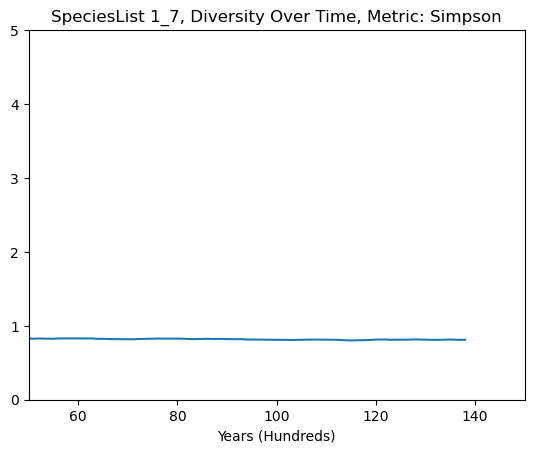

In [36]:
my_type = "Simpson"
plt.plot(list(range(len(a[my_type]))), a[my_type])
plt.title(f'SpeciesList 1_7, Diversity Over Time, Metric: {my_type}')
plt.xlabel("Years (Hundreds)")
plt.xlim(50, 150)
plt.ylim(0, 5)
plt.show()

<AxesSubplot:>

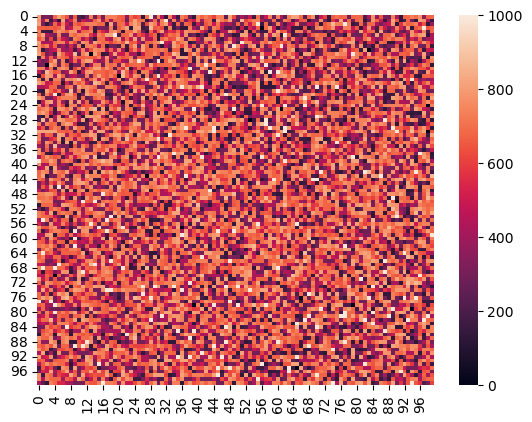

In [50]:
sns.heatmap(pd.read_csv("Completed Runs\\SpeciesList1\\ID8\\OldBase\\4000finalState.csv", header= None), vmin = 0, vmax = 1000)

In [ ]:
# By my mystical calculations, the median crown height of reproductive adults in barro colorado ~125
# Simulating a rough estimatiion of a 50ha plot would be sqrt(500000 / 125) ~ 64 x 64 plot which is what we will be simulating
# In future, we can simulate a big grid and just simply truncate it for a comparison
# For now I will be standardising to 100 x 100
# KIV CHANGING THE VALUES OF T1, T2, NS
# speciesList = generateSpeciesList(numOfSpecies = 1000, alpha = 8, beta = 5,
#                                  t1 = 9, t2 = 56, ns = 5, 
#                                  conNDD = 0.15, hetNDD = 0.006)
# sim = Simulation(speciesList = speciesList, boardLength = 100,
#                 storageLimit = 50, startNumber = 10, 
#                 boomerModel = False, stdev = 5, 
#                  printFreq = 100)
# sim.run(iterations = 300)
# speciesList.saveSpeciesData("ComitaTest.csv")

In [ ]:
Species
def __init__(self, parentID: int,
                 p1: float, p2: float, 
                 t1: int, t2: int, t3: int,
                 ns: int, 
                 conNDD: float, hetNDD: float):
        
SpeciesList 
def __init__(self):

Plant
def __init__(self, species: Species, age: int = 0): # pass the Species object into the constructor
    
Juvenile
def __init__(self, species: Species, age: int):
    
Adult
def __init__(self, species: Species, age: int):
    
DeadPlant
def __init__(self, species: Species, age: int):

PlantArray
def __init__(self, storageLimit : int):
    
Tile
def __init__(self, storageLimit : int):

Board
def __init__(self, speciesList: SpeciesList, boardLength: int, 
                storageLimit : int, startNumber : int,
                boomerModel : bool,
                stdev : int, 
                printFreq : int):

Simulation
    def __init__(self, speciesList: SpeciesList, boardLength: int,
                storageLimit : int = 50, startNumber : int = 5, 
                boomerModel: bool = False, stdev : int = 5, 
                printFreq : int = 100):